In [362]:
from acevedo_clss_and_fcns import * 
device = 'cpu'
if torch.cuda.is_available():
    torch.cuda.init()
    if torch.cuda.is_initialized():
        device = 'cuda:0'
#device = torch.device(device)
print(f"{device = }")
from torch_geometric.nn import GNNExplainer

    

model = torch.load(
"./results/trained_pytorch_models/PKU//Model_GIN_classifier_to_explain_v2_20-10-2022_21h_43min_best_ValAcc_0.988306299509619_epoch_4.pt")
#loader_path = "./results/dataloaders/MASKED_loader_Concen_plus_Fluxes.pt"
loader_path = "./results/dataloaders/loader_Concen_plus_Fluxes.pt"
loader = torch.load(loader_path)
loader_validation = loader.get_validation_loader()
loader_train = loader.get_train_loader()
############################
##############################
explainer  = GNNExplainer(model, epochs=1000, num_hops = None, lr=0.01).to(device, non_blocking=True)
model.to(device, non_blocking=True)
a_batch = next(iter(loader_validation)).to(device, non_blocking=True)

loader_train.dataset



device = 'cuda:0'


[Data(x=[12228, 1], edge_index=[2, 53122], y=[1], num_classes=2),
 Data(x=[12228, 1], edge_index=[2, 53122], y=[1], num_classes=2),
 Data(x=[12228, 1], edge_index=[2, 53122], y=[1], num_classes=2),
 Data(x=[12228, 1], edge_index=[2, 53122], y=[1], num_classes=2),
 Data(x=[12228, 1], edge_index=[2, 53122], y=[1], num_classes=2),
 Data(x=[12228, 1], edge_index=[2, 53122], y=[1], num_classes=2),
 Data(x=[12228, 1], edge_index=[2, 53122], y=[1], num_classes=2),
 Data(x=[12228, 1], edge_index=[2, 53122], y=[1], num_classes=2),
 Data(x=[12228, 1], edge_index=[2, 53122], y=[1], num_classes=2),
 Data(x=[12228, 1], edge_index=[2, 53122], y=[1], num_classes=2),
 Data(x=[12228, 1], edge_index=[2, 53122], y=[1], num_classes=2),
 Data(x=[12228, 1], edge_index=[2, 53122], y=[1], num_classes=2),
 Data(x=[12228, 1], edge_index=[2, 53122], y=[1], num_classes=2),
 Data(x=[12228, 1], edge_index=[2, 53122], y=[1], num_classes=2),
 Data(x=[12228, 1], edge_index=[2, 53122], y=[1], num_classes=2),
 Data(x=[1

In [ ]:

model.eval()
gc.collect()
torch.cuda.empty_cache() 
#node_feat_mask, edge_mask =  explainer.explain_graph(a_batch[0].x, a_batch[0].edge_index)
_, edge_mask =  explainer.explain_graph(a_batch[0].x, a_batch[0].edge_index)



In [42]:
edge_mask.cpu().numpy().min(), edge_mask.cpu().numpy().max()

(0.008108608, 0.60636234)

In [366]:
train_labels = []
for graph in tqdm.tqdm(loader_train.dataset):
    train_labels.append(graph.y.cpu().item())
train_labels.__len__()

100%|██████████| 4921/4921 [00:00<00:00, 385610.17it/s]


4921

In [106]:


edge_num           = loader_train.dataset[0].edge_index.shape[1]
all_graphs_weights = []#torch.empty(edge_num,1).to(device)

for graph in tqdm.tqdm(loader_train.dataset):
    _, edge_weights =  explainer.explain_graph(graph.x.to(device), graph.edge_index.to(device))
    #all_graphs_weights = torch.cat((all_graphs_weights, edge_weights.reshape(edge_num,1).to(device)), dim=1)
    all_graphs_weights.append(edge_weights.reshape(edge_num,1))
    


  0%|          | 0/4921 [00:00<?, ?it/s]















  0%|          | 1/4921 [00:01<2:04:41,  1.52s/it]

















  0%|          | 2/4921 [00:03<2:17:53,  1.68s/it]
















  0%|          | 3/4921 [00:04<2:14:55,  1.65s/it]
















  0%|          | 4/4921 [00:06<2:13:55,  1.63s/it]
















  0%|          | 5/4921 [00:08<2:13:38,  1.63s/it]















  0%|          | 6/4921 [00:09<2:11:51,  1.61s/it]















  0%|          | 7/4921 [00:11<2:09:31,  1.58s/it]















  0%|          | 8/4921 [00:12<2:07:29,  1.56s/it]
















  0%|          | 9/4921 [00:14<2:09:05,  1.58s/it]















  0%|          | 10/4921 [00:15<2:09:14,  1.58s/it]















  0%|          | 11/4921 [00:17<2:08:19,  1.57s/it]















  0%|          | 12/4921 [00:19<2:08:48,  1.57s/it]















  0%|          | 13/4921 [00:20<2:07:36,  1.56s/it]















  0%|          | 14/4921 [00:22<2:07:07,  1.55s/it]
















  0%|   

array([<AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>,
       <AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>,
       <AxesSubplot:ylabel='Frequency'>], dtype=object)

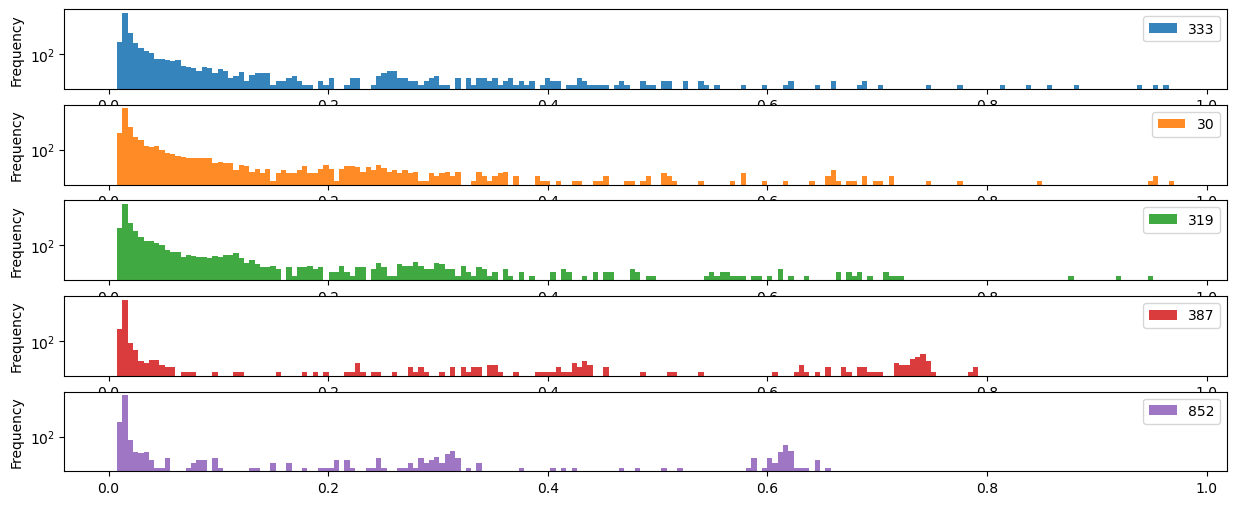

In [380]:
import numpy as np
all_graphs_weights_df = pd.DataFrame(
torch.stack(all_graphs_weights,1).squeeze().cpu().numpy())



all_graphs_weights_df.loc[:,np.random.randint(1, 1000, 5)].plot.hist(bins=200, alpha=0.9, figsize=(15,6), subplots=True, sharey=False, 
                      sharex=False, logy = True, ylabel = ['', '', ''], grid=False)


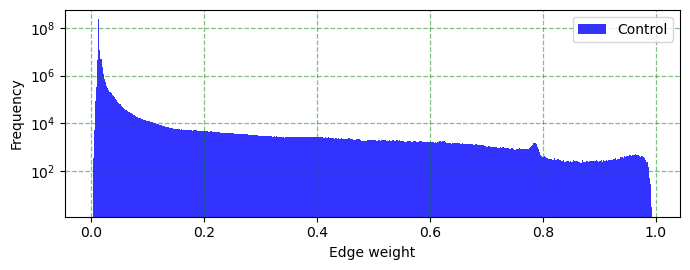

In [381]:

all_graphs_weights_df.stack().reset_index(drop=True).plot.hist(bins=500, logy = True, figsize=(7,2.8), grid=False, color = 'blue', alpha=.8)
plt.xlabel('Edge weight')
plt.tight_layout()
plt.grid(color = 'green', linestyle = '--', linewidth = 0.9, alpha=.5)
#plt.xlim([0, 1])
plt.legend(['Control'])
plt.show()


<AxesSubplot:ylabel='Frequency'>

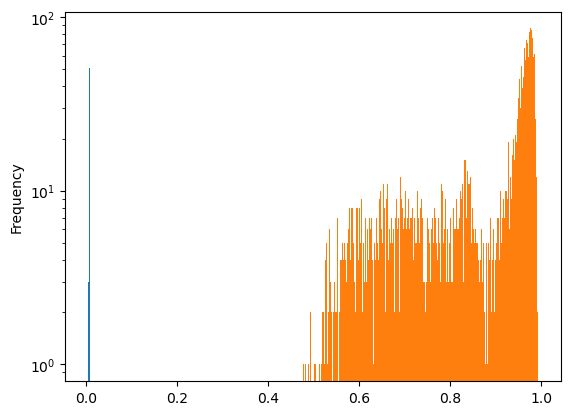

In [382]:
all_graphs_weights_df.min().plot.hist(logy = True, bins=500)


all_graphs_weights_df.max().plot.hist(logy = True, bins=500)

(2657, 4921)

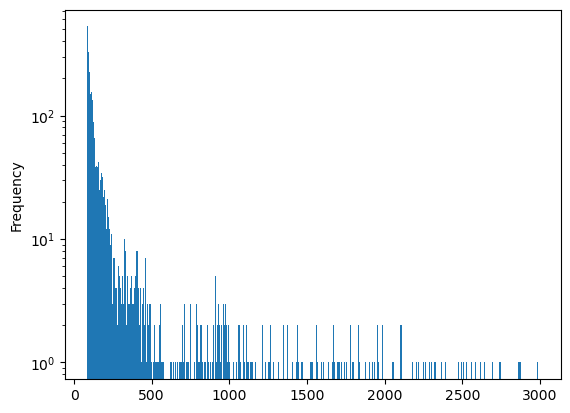

In [384]:

filtered_graph_weights_df = all_graphs_weights_df.loc[all_graphs_weights_df.sum(axis=1) > np.percentile(all_graphs_weights_df.sum(axis=1), 95)  , :]

filtered_graph_weights_df.sum(axis=1).plot.hist(logy = True, bins=500)
filtered_graph_weights_df.shape

<AxesSubplot:ylabel='Frequency'>

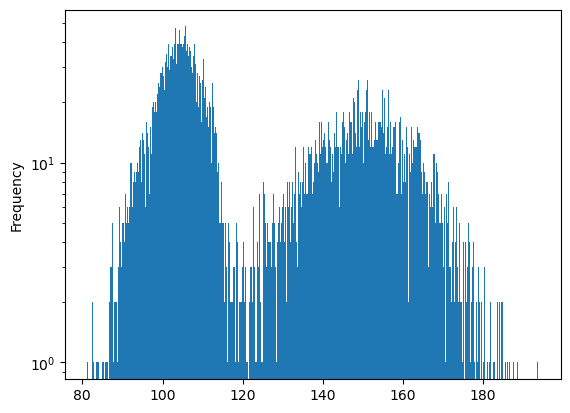

In [385]:

filtered_graph_weights_df.sum(axis=0).plot.hist(logy = True, bins=500)


In [386]:

filtered_graph_weights = filtered_graph_weights_df.transpose() #.columns = train_labels
filtered_graph_weights["Label"] = ["PKU" if l == 0 else "Control" for l in train_labels] 

filtered_graph_weights.reset_index(drop=True, inplace=True)
filtered_graph_weights.columns = [str(col) for col in filtered_graph_weights.columns]
filtered_graph_weights.to_parquet('./results/data/filtered_graph_weights.parquet.gzip', compression = 'gzip')

ValueError: parquet must have string column names

In [138]:
edge_0_node_idxs =  pyg_graph.edge_index[0,:]
edge_1_node_idxs =  pyg_graph.edge_index[1,:]
edge_0_nodes     = [list(nx_G.nodes)[i] for i in  edge_0_node_idxs]
edge_1_nodes     = [list(nx_G.nodes)[i] for i in  edge_1_node_idxs]

NameError: name 'pyg_graph' is not defined

In [5]:
edges_df = pd.DataFrame({'node1': edge_0_nodes, 'node2':edge_1_nodes})
edges_node_names_explainer_subgraphs = pd.concat([edges_df, explainer_subgraphs_df], axis=1)

In [6]:
edges_node_names_explainer_subgraphs

,node1,node2,0
0,FPGS8,10fthf5glu_c,0.0
1,FPGS8,10fthf6glu_c,0.0
2,FPGS8,atp_c,0.0
3,FPGS8,adp_c,0.0
4,FPGS8,glu_L_c,0.0
...,...,...,...
53117,r1947,lys_L_e,0.0
53118,r1947,tyr_L_e,0.0
53119,gp1calpha_hs_e,EX_gp1calpha_hs_e,0.0
53120,gp1calpha_hs_e,GP1CALPHAte,0.0


In [7]:
edges_node_names_explainer_subgraphs.to_csv("./results/data/edges_node_names_explainer_subgraphs.csv")
